## Rainfall Prediction over Michigan Lake using CNN and RNN
---------------------------------------
<div align="right">
    <b>Teammates:</b><br>
    Krishnakanth Naik Jarapala<br>
    Uday Kiran Dasari
</iv>


**Notoebook Summary**: *Due to the disparity in the dataset sizes between cloud data (with only 8 records per day) and meteorological data, integrating the features extracted from images with the meteorological data poses a challenge. It's unclear how to effectively combine the 8-record cloud information extracted from the CNN with the 24-record meteorological data from the RNN model. This led us to consider dividing the day into three 8-hour shifts and incorporating the CNN information with the afternoon meteorological data.*

* Here we are using the Cloud-Cover feature ==> by computing the Pixel Intensity from the Cloud Images and integrated with Meteo data.
* In every 8-hour shift, we consider the record which has highest precip_in value. so, we have 3 rows/records per day.
* In the current notebook, we train only a **RNN model** on **Meteo data along with cloud-cover** feature.

## Preprocessing

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import tempfile

import sklearn
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

2024-04-24 23:38:20.728657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:38:25.162534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('./data/full_data_2014_2017_with_intensity.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['year_month'] = df['datetime'].dt.strftime('%Y-%m')

# Set max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

df = df.sort_values(['datetime']).reset_index(drop=True)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in
0,2006-10-01,00:00,2006-10-01 00:00:00,2006-10,48.0,86.0,7,150,4100,10,984.0,0.0,0.00
1,2006-10-01,01:00,2006-10-01 01:00:00,2006-10,48.0,86.0,8,150,6000,10,983.7,0.0,0.00
2,2006-10-01,02:00,2006-10-01 02:00:00,2006-10,48.0,86.0,6,150,5500,10,982.7,0.0,0.00
3,2006-10-01,03:00,2006-10-01 03:00:00,2006-10,48.0,86.0,8,150,6000,10,982.0,0.0,0.00
4,2006-10-01,04:00,2006-10-01 04:00:00,2006-10,48.0,89.0,5,150,2200,8,982.0,0.0,0.02


In [3]:
recent_10k_records = df.year_month.unique().tolist()[-18:]

print(f"Selecting the data from this time period: {recent_10k_records}")
df = df[df.year_month.isin(recent_10k_records)].sort_values('datetime').reset_index(drop=True)
df.head()

Selecting the data from this time period: ['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']


,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,49.0,89.0,8,360,600,6,993.0,0.0,0.04
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,48.0,87.0,10,30,1200,8,993.0,0.0,0.01
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,48.0,86.0,8,50,1000,10,993.7,0.0,0.00


In [4]:
df.year_month.unique()

array(['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03'],
      dtype=object)

In [5]:
df[df.Precip_in>0].Precip_in.describe()

count    1051.000000
mean        0.031465
std         0.038859
min         0.010000
25%         0.010000
50%         0.020000
75%         0.040000
max         0.450000
Name: Precip_in, dtype: float64

### Cloud-Image data is missing for below time period, so remove them from the dataset

['2007-12', '2008-01', '2008-02',
 '2008-03', '2008-10', '2008-11]

In [6]:
df.shape

(13128, 13)

In [7]:
# missing_cloud_img_data_time = ['2007-12', '2008-01', '2008-02', '2008-03', '2008-10', '2008-11', '2007-10', '2007-11', '2008-12', '2009-01', '2009-02', '2009-03']

# df = df[~df.year_month.isin(missing_cloud_img_data_time)].reset_index(drop=True)

### Feature Engineering - Timestamp and (wind_Speed + Wind_Direction)
* Timestamp makes no-sense - so lets convert that feature into a signal using sine and cos - create day & year of signals.
* If there is no-wind, then wind-direction doesn't matter - create a wind-vector (Wx, Wy) - which considers both direction and speed.

*Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly.*
* Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/h]')

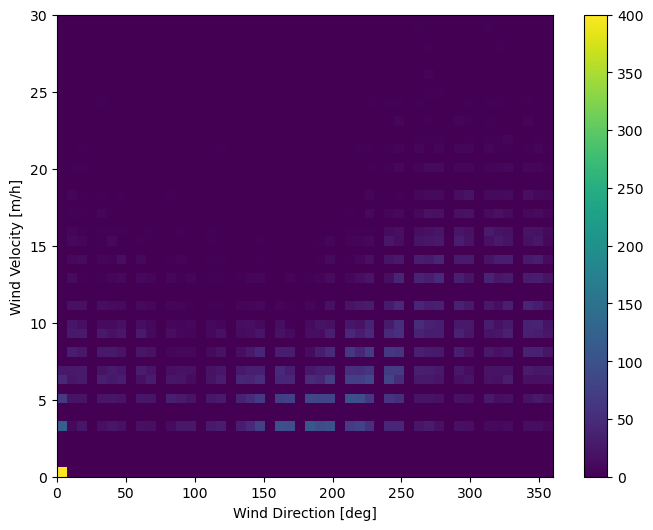

In [8]:
plt.hist2d(df['Wind_Direction_deg'], df['Wind_Spd_mph'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/h]')

*Create a Wind Vector (Wx, Wy) - using Wind-Direction + Wind-Speed - this will be easier for the model to interpret*

In [9]:
# Multiple wind_speed * Wind_Direction_in_rads along with cos & sine signals
df['Wind_x'] = (df['Wind_Spd_mph']) * np.cos(df['Wind_Direction_deg'] * np.pi / 180)
df['Wind_y'] = (df['Wind_Spd_mph']) * np.sin(df['Wind_Direction_deg'] * np.pi / 180)

df.head(2)

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in,Wind_x,Wind_y
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05,9.526279,-5.500000
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05,8.457234,-3.078181


The distribution of wind vectors is much simpler for the model to correctly 


(-20.673237657289985, 25.0, -30.0, 18.79385241571817)

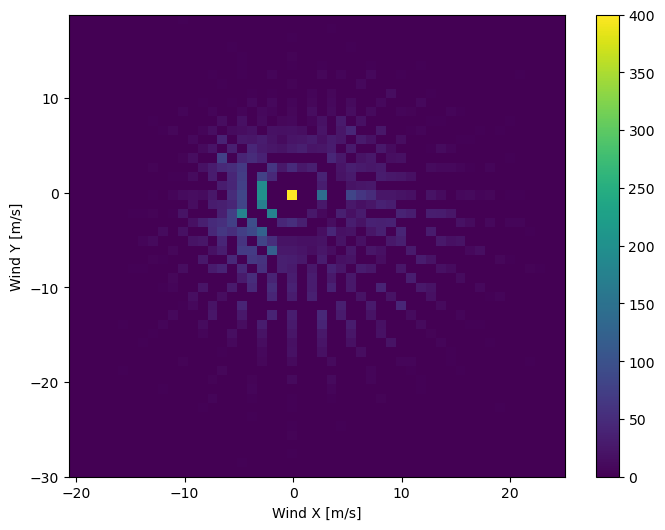

In [10]:
plt.hist2d(df['Wind_x'], df['Wind_y'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to frequency signals using Cos & Sine signals:

In [11]:
df['ts'] = df['datetime'].map(pd.Timestamp.timestamp)

# Convert the Timestamp into Cos-Sin signals - by Day & Year
day = 24*60*60
year = (365.2425)*day

df['day_sin'] = np.sin(df['ts'] * (2 * np.pi / day))
df['day_cos'] = np.cos(df['ts'] * (2 * np.pi / day))
df['year_sin'] = np.sin(df['ts'] * (2 * np.pi / year))
df['year_cos'] = np.cos(df['ts'] * (2 * np.pi / year))

In [12]:
df.head()

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in,Wind_x,Wind_y,ts,day_sin,day_cos,year_sin,year_cos
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05,9.526279,-5.500000e+00,1.412122e+09,-1.331485e-12,1.000000,-0.999946,-0.010354
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05,8.457234,-3.078181e+00,1.412125e+09,2.588190e-01,0.965926,-0.999954,-0.009637
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,49.0,89.0,8,360,600,6,993.0,0.0,0.04,8.000000,-1.959435e-15,1.412129e+09,5.000000e-01,0.866025,-0.999960,-0.008920
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,48.0,87.0,10,30,1200,8,993.0,0.0,0.01,8.660254,5.000000e+00,1.412132e+09,7.071068e-01,0.707107,-0.999966,-0.008203
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,48.0,86.0,8,50,1000,10,993.7,0.0,0.00,5.142301,6.128356e+00,1.412136e+09,8.660254e-01,0.500000,-0.999972,-0.007487


Text(0.5, 1.0, 'Time of day signal')

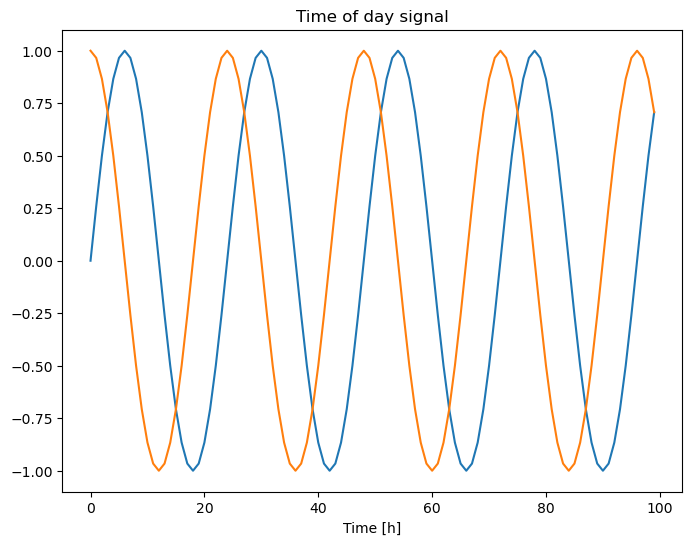

In [13]:
plt.plot(np.array(df['day_sin'])[:100])
plt.plot(np.array(df['day_cos'])[:100])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of day signal')

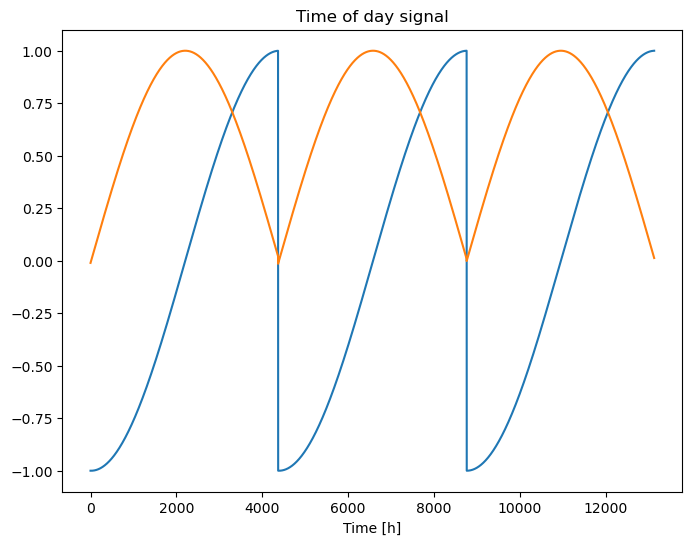

In [14]:
plt.plot(np.array(df['year_sin']))
plt.plot(np.array(df['year_cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Drop unnecessary features and prepare the final set of data

In [15]:
features_to_consider =  ['datetime', 'year_month', 'Time_UTC', 'year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 
    'RH_pct', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa', 'cloud_cover', 
    'Wind_x', 'Wind_y',  'Precip_in']

df_raw = df.copy()

df = df[features_to_consider]
df.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.0,9.526279,-5.500000e+00,0.05
1,2014-10-01 01:00:00,2014-10,01:00,-0.999954,-0.009637,2.588190e-01,0.965926,48.0,93.0,800,4,993.3,0.0,8.457234,-3.078181e+00,0.05
2,2014-10-01 02:00:00,2014-10,02:00,-0.999960,-0.008920,5.000000e-01,0.866025,49.0,89.0,600,6,993.0,0.0,8.000000,-1.959435e-15,0.04
3,2014-10-01 03:00:00,2014-10,03:00,-0.999966,-0.008203,7.071068e-01,0.707107,48.0,87.0,1200,8,993.0,0.0,8.660254,5.000000e+00,0.01
4,2014-10-01 04:00:00,2014-10,04:00,-0.999972,-0.007487,8.660254e-01,0.500000,48.0,86.0,1000,10,993.7,0.0,5.142301,6.128356e+00,0.00


* Above dataset is the cleaned, processed along with cloud-cover (pixel-intensity of clouds) information.

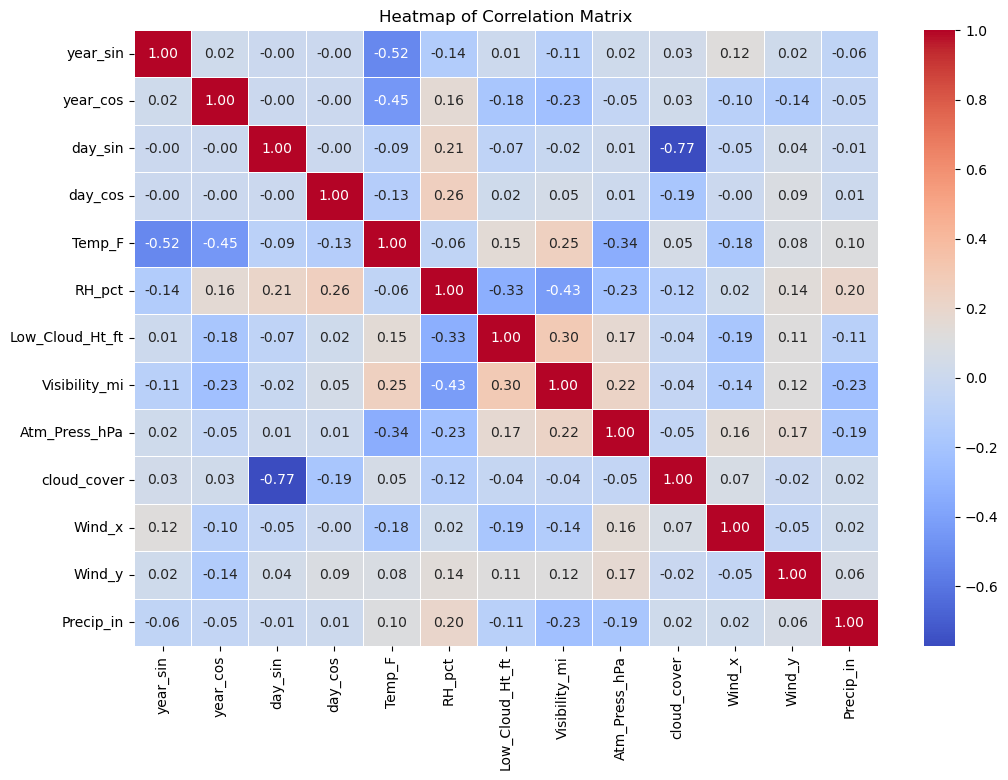

In [16]:
correlation_matrix = df.iloc[:, 3:].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)


In [18]:
# features_considered = df.columns.tolist()[2:]

# features1 = df[features_considered]
# # features1.index = df['datetime']
# features1.index = df['year_cos']

# features1.head()

# mpl.rcParams['figure.figsize'] = (16, 15)
# features1.plot(subplots=True)

In [19]:
df[df.Precip_in > 0].Precip_in.describe()

count    1051.000000
mean        0.031465
std         0.038859
min         0.010000
25%         0.010000
50%         0.020000
75%         0.040000
max         0.450000
Name: Precip_in, dtype: float64

* Data is not continuous, so lets create the sequence dataset by each window of 6-months

In [20]:
mnts= df.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])

yr_mnt_lst

[['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'],
 ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03'],
 ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']]

In [21]:
df['day_session'] = df['Time_UTC'].apply(lambda x: (int(x[:2])//8))
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')


### Creating a new dataset - have 3 records per day where we select the max precip record from one of the 8-hour duration (day-session)
* 0-8 ==> day-session- 1
* 8-16 ==> day-session- 2
* 16-24 ==> day-session- 3

In [22]:
df['RN'] = df.sort_values(['date','day_session', 'Precip_in'], ascending=[True,True, False]).groupby(['date','day_session']).cumcount()+1

filtered_data = df[df.RN == 1].sort_values('datetime').reset_index(drop=True)
filtered_data.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1


In [23]:
# # Step 1: Group by date and rounded hour, then create a new DataFrame with mean and max values for specified columns
# df_avg_max = df.groupby(['date', 'day_session']).agg({
#     'Temp_F': 'mean',
#     'RH_pct': 'mean',
#     'Wind_Spd_mph': 'mean',
#     'Wind_Direction_deg': 'mean',
#     'Low_Cloud_Ht_ft': 'mean',
#     'Visibility_mi': 'mean',
#     'Low_Cloud_Ht_ft': 'mean',
#     'Atm_Press_hPa': 'mean',
#     'cloud_cover': 'max',      # Calculate mean for cloud_cover
#     'Precip_in': 'max',            # Calculate max for precip
# }).reset_index()

# df_avg_max

In [24]:
filtered_data.shape

(1641, 19)

Preprocessing the Data for Training

In [25]:
# Creating the windows where the data is continuous
window1 = ['2014-10', '2014-11', '2014-12', '2015-01','2015-02', '2015-03']
window2 = ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03']
window3 = ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']


tdf = filtered_data.copy()
tdf['time_seq_window'] = -1 #imputting the window values with -1

tdf.loc[tdf.year_month.isin(window1), 'time_seq_window'] = 1
tdf.loc[tdf.year_month.isin(window2), 'time_seq_window'] = 2
tdf.loc[tdf.year_month.isin(window3), 'time_seq_window'] = 3

tdf.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN,time_seq_window
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1,1
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1,1
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1,1


In [26]:
tdf.groupby(['year_month', 'time_seq_window'])['datetime'].count()

year_month  time_seq_window
2014-10     1                  93
2014-11     1                  90
2014-12     1                  93
2015-01     1                  93
2015-02     1                  84
2015-03     1                  93
2015-10     2                  93
2015-11     2                  90
2015-12     2                  93
2016-01     2                  93
2016-02     2                  87
2016-03     2                  93
2016-10     3                  93
2016-11     3                  90
2016-12     3                  93
2017-01     3                  93
2017-02     3                  84
2017-03     3                  93
Name: datetime, dtype: int64

In [27]:
tdf.Precip_in.describe()

count    1641.000000
mean        0.008952
std         0.028463
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.450000
Name: Precip_in, dtype: float64

In [28]:
tdf[tdf.Precip_in > 0].Precip_in.describe()

count    377.000000
mean       0.038966
std        0.048589
min        0.010000
25%        0.010000
50%        0.020000
75%        0.050000
max        0.450000
Name: Precip_in, dtype: float64

#### Create a Precip_in Class:
        * 0 - No Rain
        * (0 - 0.019) - Med Rain
        * anything above 0.019 - High Rain

In [29]:
def classify_precip(val):
    high_rain_lower_limit = 0.020
    if val == 0:
        return "No_Rain"
    elif (val > 0) & (val <= high_rain_lower_limit):
        return "Medium_Rain"
    elif (val > high_rain_lower_limit):
        return "High_Rain"

In [30]:
tdf['Precip_in_class'] = tdf['Precip_in'].apply(lambda x: classify_precip(x))
100*tdf.Precip_in_class.value_counts(normalize=True)

Precip_in_class
No_Rain        77.026204
Medium_Rain    12.675198
High_Rain      10.298598
Name: proportion, dtype: float64

In [31]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming your class variable is named 'classes' and it is a list or array
classes = tdf['Precip_in_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
label_binarizer = LabelBinarizer()
one_hot_encoded = label_binarizer.fit_transform(classes)

# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
tdf_with_one_hot = pd.concat([tdf, one_hot_df], axis=1)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

print("One-hot encoded:")
print(one_hot_encoded)
print("Class weights:")
print(class_weights)


One-hot encoded:
[[1 0 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
Class weights:
[3.23668639 2.62980769 0.43275316]


In [32]:
tdf_with_one_hot.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN,time_seq_window,Precip_in_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1,1,High_Rain,1,0,0
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1,1,No_Rain,0,0,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1,1,No_Rain,0,0,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1,1,High_Rain,1,0,0
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1,1,High_Rain,1,0,0


### Earlier the Class-Distribution was 92% - No-Rain and 8%-Rain, Now after considering single record per every 8-hour, the distribution changed to below:

In [33]:
tdf.shape,tdf.Precip_in_class.value_counts(normalize=True)

((1641, 21),
 Precip_in_class
 No_Rain        0.770262
 Medium_Rain    0.126752
 High_Rain      0.102986
 Name: proportion, dtype: float64)

### All the Data Prepocessing is completed and the data is ready for creating the sequence dataset

*Note: As we know the data is not continuous, create the sequence dataset using the timewindows*

In [34]:
tdf_with_one_hot.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN,time_seq_window,Precip_in_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1,1,High_Rain,1,0,0
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1,1,No_Rain,0,0,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1,1,No_Rain,0,0,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1,1,High_Rain,1,0,0
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1,1,High_Rain,1,0,0


#### Objective: Predict the Precip_in value instead of the Classes

In [35]:
cols_to_use = ['datetime', 'year_month', 'time_seq_window', 'year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 
        'Low_Cloud_Ht_ft', 'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover', 'Precip_in']
        # 'High_Rain', 'Medium_Rain', 'No_Rain']

final_df = tdf_with_one_hot[cols_to_use].copy()
final_df = final_df.sort_values('datetime').reset_index(drop=True)
final_df.head()

,datetime,year_month,time_seq_window,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Wind_x,Wind_y,Atm_Press_hPa,cloud_cover,Precip_in
0,2014-10-01 00:00:00,2014-10,1,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,9.526279,-5.500000e+00,992.7,0.000000,0.05
1,2014-10-01 08:00:00,2014-10,1,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,0.000000,0.000000e+00,995.0,0.000000,0.00
2,2014-10-01 16:00:00,2014-10,1,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,-6.000000,7.347881e-16,991.3,52.587691,0.00
3,2014-10-02 07:00:00,2014-10,1,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,-2.500000,4.330127e+00,990.7,0.000000,0.11
4,2014-10-02 10:00:00,2014-10,1,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,-2.298133,1.928363e+00,989.7,0.000000,0.28


* Standarize the features: 

   *['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Wind_Direction_deg', 'Low_Cloud_Ht_ft', 'Visibility_mi','Atm_Press_hPa', 'cloud_cover']*

In [36]:
final_df.shape

(1641, 16)

In [37]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Windows - to select the dataset
train_data_windows = [1,2,3]

#cols to standardize
cols_to_standardize = ['year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 'Low_Cloud_Ht_ft',
    'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover']

TEST_Records = 200 # Number of Test data

# Train and Test datasets
train_df = final_df.iloc[:-TEST_Records, :].reset_index(drop=True)
test_df = final_df.iloc[-TEST_Records:, :].reset_index(drop=True)

print(f"Train Dataset shape: {train_df.shape}, Test Dataset Shape: {test_df.shape}")

# Fit and transform the scaler on the Full data
train_df_scaled = train_df.copy()
train_df_scaled[cols_to_standardize] = scaler.fit_transform(train_df[cols_to_standardize])

# Transform the test data using the same scaler
test_df_scaled = test_df.copy()
test_df_scaled[cols_to_standardize] = scaler.transform(test_df[cols_to_standardize])
print(f"Train scaled Dataset shape: {train_df_scaled.shape}, Test scaled Dataset Shape: {test_df_scaled.shape}")


Train Dataset shape: (1441, 16), Test Dataset Shape: (200, 16)
Train scaled Dataset shape: (1441, 16), Test scaled Dataset Shape: (200, 16)


In [38]:
test_df_scaled.head()

,datetime,year_month,time_seq_window,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Wind_x,Wind_y,Atm_Press_hPa,cloud_cover,Precip_in
0,2017-01-24 08:00:00,2017-01,3,0.762815,0.851802,1.196587,-0.703829,0.088088,1.668641,-0.772669,-1.260669,0.299181,-0.575661,-0.755074,-0.660445,0.00
1,2017-01-24 16:00:00,2017-01,3,0.770524,0.844324,-1.232541,-0.703829,0.154860,1.371274,-0.736217,-1.582195,0.734327,-0.528030,-0.755074,1.612341,0.00
2,2017-01-25 00:00:00,2017-01,3,0.778212,0.836748,-0.017977,1.436029,0.154860,1.594299,-0.772669,-0.617616,-0.065687,-0.120118,-0.892824,-0.660445,0.00
3,2017-01-25 14:00:00,2017-01,3,0.791620,0.823258,-0.719206,-1.225991,0.021315,1.371274,-0.772669,-1.582195,0.858190,0.915931,-1.814686,1.009375,0.02
4,2017-01-25 17:00:00,2017-01,3,0.794485,0.820329,-1.372648,-0.359767,-0.045457,1.668641,-0.772669,-2.225247,-0.065687,0.397906,-1.846474,1.312817,0.04


### Create the Sequence dataset for Training

In [39]:
# preparing independent and dependent features
def prepare_data(df, window_type, cols_to_use,  n_time_steps, future_steps):
    
    data = df[df.time_seq_window == window_type][cols_to_use].values

    # print(data[0])

    X, y =[],[]
    for i in range(len(data)):
        end_ix = i + n_time_steps #selectingg the end_idx based on the timestep

        # check if we are beyond the sequence
        if end_ix  + future_steps > len(data):
            break

        # gather input and output parts of the pattern
        seq_x = data[i:end_ix, :-3] #selecting ith to end-idx and removing label
        seq_y = data[end_ix: end_ix  + future_steps, -3:] #end-idx - last column is the label (precip_in)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_sequences(data,  feature_columns, label_columns, past_time_steps=72, future_time_steps=24):
    X, y = [], []
    
    # feature_columns = features_to_consider[:-3]  # exclude target lables, last 3 columns are the one-hot encoded labels
    # label_columns = features_to_consider[-3:]    # One-hot encoded labels
    
    for i in range(len(data) - past_time_steps - future_time_steps + 1):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].values)
        y.append(data.iloc[i + past_time_steps : i + past_time_steps + future_time_steps][label_columns].values)
    
    return np.array(X), np.array(y)

### Training Dataset 
* Historical n time steps - 72 ==> (3 days * 24 Records)
* Futures Steps - 24 hours ==> (1 days * 24 Records)

In [40]:
# selecting the most important features
cols_to_use = ['year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 'Low_Cloud_Ht_ft',
    'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover',
    'High_Rain', 'Medium_Rain', 'No_Rain']

    
n_time_steps = 9 # 24*n_days ==> considering 3 days of historical data for now
future_steps = 3 # 24*n_days ==> considering 1 day to predict in future

time_windows = [1, 2, 3] # 1, 2, 3 - time window data

# Select the features and labels
feature_columns = cols_to_use[:-3]
label_columns = ['Precip_in']

### Training Data
data_x, data_y = [], []

for i in time_windows:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y = create_sequences(train_df_scaled[train_df_scaled.time_seq_window == i], feature_columns, label_columns, n_time_steps, future_steps)

    data_x.append(x)
    data_y.append(y)

# Concatenate the arrays along the first axis after the loop
train_x = np.concatenate(data_x, axis=0)
train_y = np.concatenate(data_y, axis=0)


# data_x.shape, data_y.shape
train_x.shape, train_y.shape

((1408, 9, 12), (1408, 3, 1))

In [41]:
# test_df_scaled.time_seq_window.unique()

In [42]:
### Test Data
test_x, test_y = create_sequences(test_df_scaled, feature_columns, label_columns, n_time_steps, future_steps)
test_x.shape, test_y.shape

((189, 9, 12), (189, 3, 1))

### Steps completed so far:
* Data Cleaning
* Created Time windows - as data is not continuous, used time window to create the seq data
* One-hot encoded the labels
* Standarized the features
* Created Train & Test - Sequence data with n_historical_steps and n_future_steps

----------------------------------------
# RNN

### RNN Modelling

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'mse']
  # ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

def compute_cw_and_bias(df):

    # Calculate the counts for each class
    counts = {
        'no_rain': df['No_Rain'].sum(),
        'medium_rain': df['Medium_Rain'].sum(),
        'high_rain': df['High_Rain'].sum()
    }

    # Calculate the probabilities for each class
    total_counts = sum(counts.values())
    probabilities = {k: v / total_counts for k, v in counts.items()}

    # Calculate the initial bias for each class
    # In this case, we use 'no_rain' as the reference class probability
    reference_probability = probabilities['no_rain']
    initial_biases = np.log([
        probabilities['high_rain'] / reference_probability,
        probabilities['medium_rain'] / reference_probability,
        probabilities['no_rain'] / probabilities['no_rain']]
        )

    ######################################################################### Bias

    class_weights = {
        0: (1 / counts['high_rain']) * (total_counts / 3),
        1: (1 / counts['medium_rain']) * (total_counts / 3),
        2: (1 / counts['no_rain']) * (total_counts / 3)
    }

    ######################################################################### Class Weights


    print("Initial Biases:", initial_biases)
    print("Class Weights:", class_weights)

    # Computing the class weights
    class_weights_list = []
    for k, v in class_weights.items():
        class_weights_list.append(v)

    print("Class Weights List:", class_weights_list)


    return initial_biases, class_weights


def build_smaller_rnn_model(train_x, train_y,  output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Define the LSTM model with TimeDistributed Dense layer
    model = Sequential([
        LSTM(20, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
        Dropout(0.5),
        LSTM(20, return_sequences=True),
        Dropout(0.5),
        Reshape((train_y.shape[1], -1)),
        TimeDistributed(Dense(train_y.shape[2],  activation = 'softmax', bias_initializer=output_bias))
    ])

    # Compile the model with Categorical Focal Crossentropy loss function and custom alpha and gamma values
    model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_reg_model(test_x, test_y, model):
    preds = model(test_x)
    print(preds.shape)

    preds_r = np.array(preds).reshape(-1, 3)
    test_y_r = test_y.reshape(-1,3)

    mae = mean_absolute_error(test_y_r, preds_r)
    mse = mean_squared_error(test_y_r, preds_r)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)

In [44]:
train_y.shape

(1408, 3, 1)

In [45]:
## Define the metrics list
# METRICS = [
#       tf.keras.metrics.CategoricalCrossentropy(name='categorical cross entropy'),  # same as model's loss
#       #tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       #tf.keras.metrics.AUC(name='auc'),
#       #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]


# Define the LSTM model with TimeDistributed Dense layer
simple_rnn_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    Reshape((train_y.shape[1], -1)),
    TimeDistributed(Dense(train_y.shape[2],))
])

# Compile the model with Categorical Focal Crossentropy loss function and custom alpha and gamma values
simple_rnn_model.compile(optimizer='adam', loss= 'mse' , metrics='mse')

simple_rnn_model.summary()


2024-04-24 23:38:43.096529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 50)             12600     
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 9, 50)             0         
                                                                 
 reshape (Reshape)           (None, 3, 150)            0         
                                                                 
 time_distributed (TimeDist  (None, 3, 1)              151       
 ributed)                                                        
                                                        

#### Model 1: Simple RNN

In [46]:
EPOCHS = 100
BATCH_SIZE = 8

# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

# Calculate the number of steps per epoch
steps_per_epoch = len(train_x) // BATCH_SIZE

# Fit the model with specified steps per epoch
history_simple_rnn_model = simple_rnn_model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=steps_per_epoch, validation_data=(test_x, test_y), verbose=1, callbacks=[early_stopping])

Epoch 1/100


2024-04-24 23:38:46.192952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2024-04-24 23:38:46.289719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b3c84542020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 23:38:46.289758: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2024-04-24 23:38:46.298171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 23:38:46.596218: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 [==============================] - 5s 9ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 7.3702e-04 - val_mse: 7.3702e-04
Epoch 2/100
176/176 [==============================] - 1s 4ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.0663e-04 - val_mse: 7.0663e-04
Epoch 3/100
176/176 [==============================] - 1s 4ms/step - loss: 8.7277e-04 - mse: 8.7277e-04 - val_loss: 6.2956e-04 - val_mse: 6.2956e-04
Epoch 4/100
176/176 [==============================] - 1s 4ms/step - loss: 8.0443e-04 - mse: 8.0443e-04 - val_loss: 6.4998e-04 - val_mse: 6.4998e-04
Epoch 5/100
176/176 [==============================] - 1s 4ms/step - loss: 7.8145e-04 - mse: 7.8145e-04 - val_loss: 6.8839e-04 - val_mse: 6.8839e-04
Epoch 6/100
176/176 [==============================] - 1s 4ms/step - loss: 7.6633e-04 - mse: 7.6633e-04 - val_loss: 6.6624e-04 - val_mse: 6.6624e-04
Epoch 7/100
176/176 [==============================] - 1s 4ms/step - loss: 7.5895e-04 - mse: 7.5895e-04 - val_loss: 6.4156e-04 - val_m

In [47]:
# Compute the model metrics on Test Data
eval_reg_model(test_x, test_y, simple_rnn_model)

(189, 3, 1)
Mean Absolute Error: 0.013834723565773458
Mean Squared Error: 0.0006481170423541595


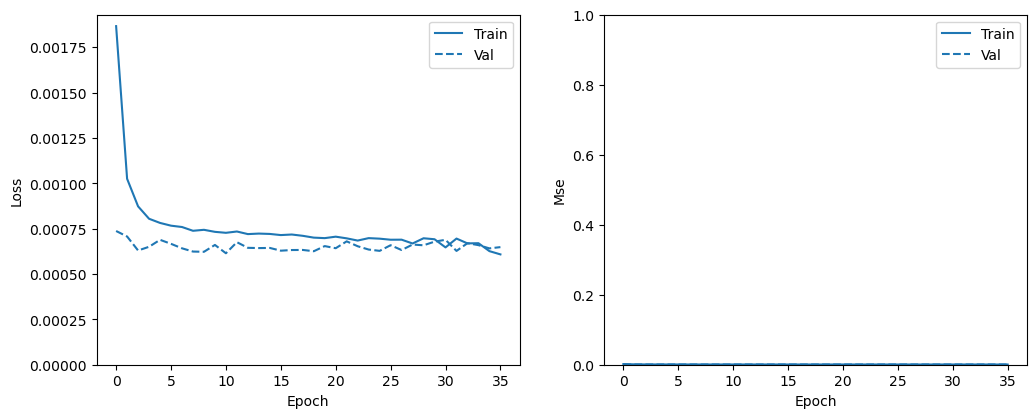

In [48]:
plot_metrics(history_simple_rnn_model)

#### Model 2: With bigger RNN Architecture

In [49]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop

def build_rnn_model(input_timesteps, output_timesteps, n_features):

    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, n_features, 1,1)))#num of records,72,12,1,1
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, n_features, 1,64)))#(None, 24, 12, 64)
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    #model.add(TimeDistributed(Dense(units=64, name = 'dense_1', activation = 'relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(units=1, name = 'output_layer')))

    optimizer = tf.keras.optimizers.Adam()

    # optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
#    model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , optimizer = optimizer, metrics = ['accuracy'])
    
    model.compile(
    loss = 'mse' ,
    optimizer = optimizer, 
    metrics = 'mse')
    
    return model

In [50]:
# Reshape rnn_train_x to include height, width, channel, 1, 1 to make it 5 dimensions
train_x_reshaped = train_x.reshape((train_x.shape[0], train_x.shape[1], train_x.shape[2], 1, 1))
test_x_reshaped = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2], 1, 1))

# Output the new shape
print(train_x_reshaped.shape)

(1408, 9, 12, 1, 1)


In [51]:
EPOCHS = 100
BATCH_SIZE = 8

past_time_steps = train_x.shape[1]
future_steps = train_y.shape[1]
n_features = train_x.shape[2]


# Initialize the Model
big_rnn_model = build_rnn_model(past_time_steps, future_steps, n_features) 

# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

# Fit the model
history_big_rnn_model = big_rnn_model.fit(
    train_x_reshaped,
    train_y,
    epochs=100,                    # Number of epochs to train for
    batch_size=BATCH_SIZE,         # Number of samples per gradient update
    validation_data=(test_x_reshaped, test_y),  # Use explicit validation data
    callbacks=[early_stopping],
    verbose=1)


Epoch 1/100


2024-04-24 23:39:19.195077: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


176/176 [==============================] - 13s 44ms/step - loss: 0.0601 - mse: 0.0601 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 2/100
176/176 [==============================] - 7s 38ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/100
176/176 [==============================] - 7s 41ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/100
176/176 [==============================] - 7s 40ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 5/100
176/176 [==============================] - 7s 42ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 6/100
176/176 [==============================] - 7s 39ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 7.8155e-04 - val_mse: 7.8155e-04
Epoch 7/100
176/176 [==============================] - 7s 38ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/100
176/176 [==============================] - 7s 37ms/st

In [52]:
# Compute the model metrics on Test Data
eval_reg_model(test_x_reshaped, test_y, big_rnn_model)

(189, 3, 1)
Mean Absolute Error: 0.016273108013696986
Mean Squared Error: 0.0006351049223313029


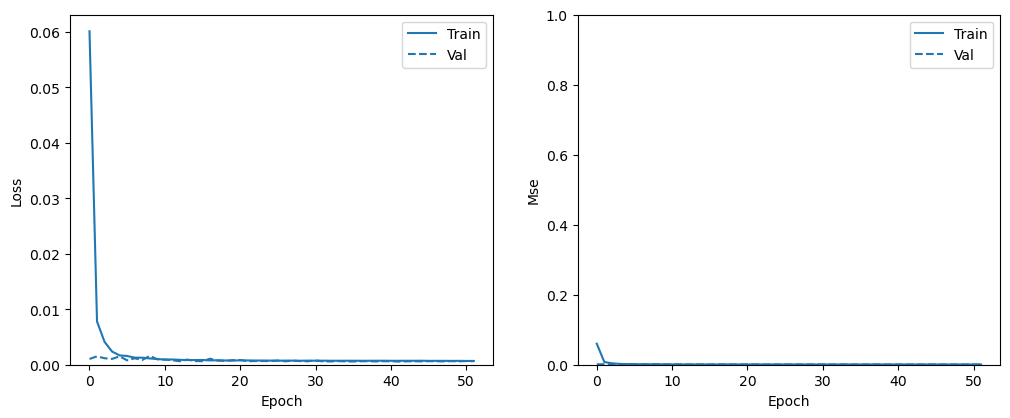

In [53]:
plot_metrics(history_big_rnn_model)


#### Model 3: Bigger RNN Architecture + RMSProp

In [54]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop

def build_rnn_model_with_rmsprop(input_timesteps, output_timesteps, n_features):

    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, n_features, 1,1)))#num of records,72,12,1,1
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, n_features, 1,64)))#(None, 24, 12, 64)
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    #model.add(TimeDistributed(Dense(units=64, name = 'dense_1', activation = 'relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(units=1, name = 'output_layer')))

    # optimizer = tf.keras.optimizers.Adam()

    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
#    model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , optimizer = optimizer, metrics = ['accuracy'])
    
    model.compile(
    loss = 'mse' ,
    optimizer = optimizer, 
    metrics = 'mse')
    
    return model

In [55]:
EPOCHS = 100
BATCH_SIZE = 8

past_time_steps = train_x.shape[1]
future_steps = train_y.shape[1]
n_features = train_x.shape[2]


# Initialize the Model
big_rnn_model_with_rms = build_rnn_model_with_rmsprop(past_time_steps, future_steps, n_features) 

# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

# Fit the model
history_big_rnn_model_with_rms = big_rnn_model_with_rms.fit(
    train_x_reshaped,
    train_y,
    epochs=100,                    # Number of epochs to train for
    batch_size=BATCH_SIZE,         # Number of samples per gradient update
    validation_data=(test_x_reshaped, test_y),  # Use explicit validation data
    callbacks=[early_stopping],    verbose=1)


Epoch 1/100


2024-04-24 23:45:29.820008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


176/176 [==============================] - 13s 47ms/step - loss: 0.0868 - mse: 0.0868 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 6.4108e-04 - val_mse: 6.4108e-04
Epoch 3/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 6.7776e-04 - val_mse: 6.7776e-04
Epoch 4/100
176/176 [==============================] - 7s 42ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 6.2200e-04 - val_mse: 6.2200e-04
Epoch 5/100
176/176 [==============================] - 8s 44ms/step - loss: 9.7870e-04 - mse: 9.7870e-04 - val_loss: 6.2311e-04 - val_mse: 6.2311e-04
Epoch 6/100
176/176 [==============================] - 8s 43ms/step - loss: 9.1624e-04 - mse: 9.1624e-04 - val_loss: 7.9787e-04 - val_mse: 7.9787e-04
Epoch 7/100
176/176 [==============================] - 8s 43ms/step - loss: 8.9740e-04 - mse: 8.9740e-04 - val_loss: 6.1726e-04 - val_mse: 6.1726e-04
E

In [56]:
# Compute the model metrics on Test Data
eval_reg_model(test_x_reshaped, test_y, big_rnn_model_with_rms)

(189, 3, 1)
Mean Absolute Error: 0.012830069452898683
Mean Squared Error: 0.0006842101107699498


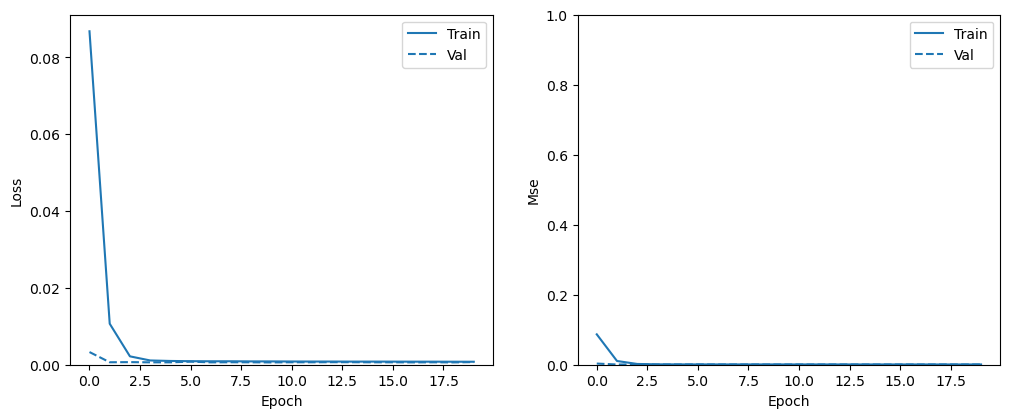

In [57]:
plot_metrics(history_big_rnn_model_with_rms)

## Conclusion

Model Performance Summary:

**Model 1: Simple RNN Model**

Mean Absolute Error: 0.013834723565773458

Mean Squared Error: 0.0006481170423541595

**Model 2: Bigger RNN Model + Adam Optimizer**

Mean Absolute Error: 0.016273108013696986

Mean Squared Error: 0.0006351049223313029

**Model 3: Bigger RNN Model + RMSProp Optimizer**

Mean Absolute Error: 0.012830069452898683

Mean Squared Error: 0.000684210110769949


